In [1]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import cross_val_score
from numpy.random import default_rng
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [2]:
data = np.genfromtxt('../A3_datasets/bm.csv', delimiter=',')
X, y = data[:, :-1], data[:, -1]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [4]:
# create 100 bootstrapped training datasets
rng = np.random.default_rng()
n = 5000
r = np.zeros([n, 100], dtype=int)
XX = np.zeros([n, 2, 100])

for i in range(100):
    r[:, i] = rng.choice(n, size=n, replace=True)
    XX[:, :, i] = X_train[r[:, i], :]

In [5]:
# train 100 decision trees on the bootstrapped datasets
decision_trees = []

for i in range(100):
    tree = DecisionTreeClassifier()
    tree.fit(XX[:, :, i], y_train[r[:, i]])
    decision_trees.append(tree)

In [6]:
# ensemble prediction on test set
pred = []
for i in range(100):
    y_pred = decision_trees[i].predict(X_test)
    pred.append(y_pred)

ensemble_prediction = np.zeros(X_test.shape[0])
for i in range(X_test.shape[0]):
    ensemble_prediction[i] = np.argmax(np.bincount([pred[j][i] for j in range(100)]))

a) The estimate of the generalization error using the test set of the ensemble of 100 decision trees.

In [7]:
ensemble_err = sum(ensemble_prediction != y_test) / len(y_test) * 100
print('The estimate of the generalization error: {:.2f}%'.format(ensemble_err))

The estimate of the generalization error: 2.20%


b) The average estimated generalization error of the individual decision trees.


In [8]:
tree_errors = []
for i in range(100):
    y_pred = decision_trees[i].predict(X_test)
    tree_err = sum(y_pred != y_test) / len(y_test)
    tree_errors.append(tree_err)

avg_error = np.mean(tree_errors)
print('The average estimated generalization error: {:.2f}%'.format(avg_error * 100))

The average estimated generalization error: 3.34%


c) the decision boundaries of all the models, and including the ensemble model

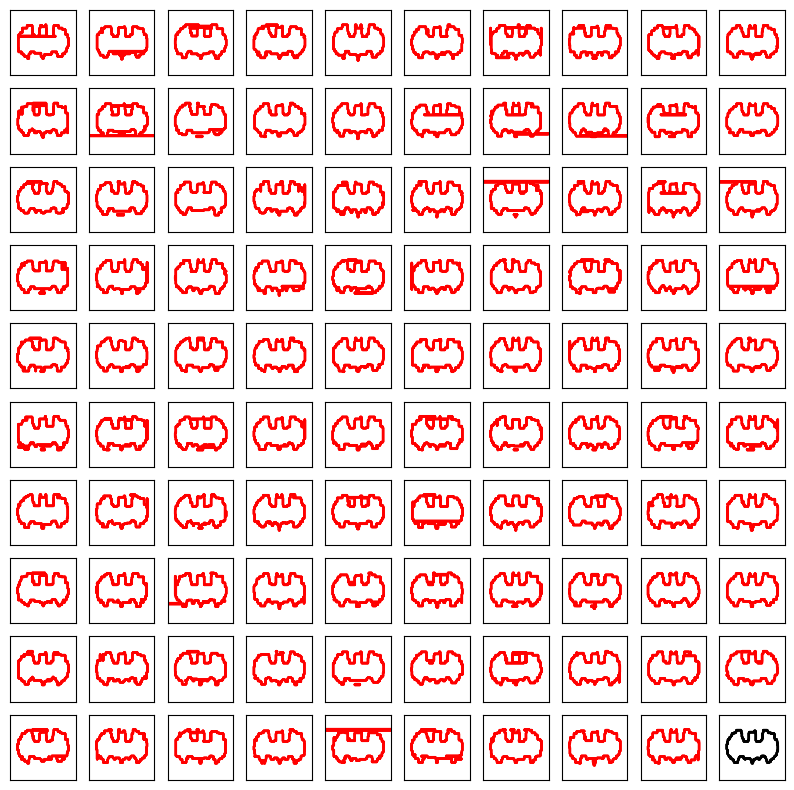

In [9]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10,10))

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))

# Plot the decision boundary for the models
for i, tree in enumerate(decision_trees):
    if i == 99:
        continue

    row = i // 10
    col = i % 10
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    ax[row][col].contour(xx, yy, Z, colors='red')
    ax[row][col].set_xticks(())
    ax[row][col].set_yticks(())

# Plot the decision boundary for the ensemble model
predictions = np.zeros((len(np.c_[xx.ravel(), yy.ravel()]), 100),  dtype=int)

for i in range(100):
    predictions[:, i] = decision_trees[i].predict(np.c_[xx.ravel(), yy.ravel()])

ensemble_predictions = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr=predictions)
ensemble_predictions = ensemble_predictions.reshape(xx.shape)

ax[-1][-1].contour(xx, yy, ensemble_predictions, colors='black')
ax[-1][-1].set_xticks(())
ax[-1][-1].set_yticks(())

plt.show()

d) Finally, a short comment on the results. Was it expected? Surprising? Do you see any benefits,downsides with this method?

These results are not surprising. Ensemble methods like random forests are known to be very effective at improving classification accuracy. <br>
One downside of this method is that it requires training and storing a large number of decision trees, which can be computationally expensive and memory-intensive. However, this can be alleviated by using techniques such as subsampling and early stopping to reduce the size of each decision tree. Another downside is that the ensemble model can be harder to interpret than the individual trees, since it combines the predictions